In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

class SentimentDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Convert to pytorch tensors
        item = {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }
        
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
            
        return item

def train_sentiment_classifier(df, text_column='clean_text', label_column='sentiment',
                              model_name="roberta-base", batch_size=16, num_epochs=3,
                              learning_rate=2e-5):
    """
    Train a sentiment classifier for ambiguous/mixed/negative/neutral/positive categories.
    
    Args:
        df: DataFrame containing text data
        text_column: Column name containing the text
        label_column: Column containing sentiment labels 
        model_name: Pretrained model name from Hugging Face
        batch_size: Batch size for processing
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimization
    
    Returns:
        Trained model, tokenizer, and label mapping
    """
    print("Preparing data...")
    
    # Create numerical mapping for labels
    unique_labels = df[label_column].unique()
    label_map = {label: i for i, label in enumerate(sorted(unique_labels))}
    inverse_label_map = {i: label for label, i in label_map.items()}
    
    print(f"Label mapping: {label_map}")
    
    # Convert labels to numeric
    df['label_numeric'] = df[label_column].map(label_map)
    
    # Check class distribution
    class_counts = df['label_numeric'].value_counts().sort_index()
    print("\nClass distribution:")
    for idx, count in class_counts.items():
        print(f"{inverse_label_map[idx]}: {count} ({count/len(df):.1%})")
    
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Split data for training
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df[text_column].tolist(), 
        df['label_numeric'].tolist(),
        test_size=0.2,
        random_state=42,
        stratify=df['label_numeric']  # Ensure balanced split
    )
    
    # Create datasets
    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
    val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model for sequence classification
    num_labels = len(label_map)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=num_labels
    )
    
    # Training parameters
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model.to(device)
    
    # Use Adam optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    
    # Training loop
    print(f"Training sentiment model for {num_epochs} epochs...")
    best_val_acc = 0
    best_model = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()
                
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        
        # Print metrics
        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Print classification report
        if epoch == num_epochs - 1:
            print("\nClassification Report:")
            label_names = [inverse_label_map[i] for i in range(len(label_map))]
            print(classification_report(all_labels, all_preds, target_names=label_names))
            
            # Plot confusion matrix
            cm = confusion_matrix(all_labels, all_preds)
            plt.figure(figsize=(10, 8))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title('Confusion Matrix')
            plt.colorbar()
            
            # Adding labels
            tick_marks = np.arange(len(label_map))
            plt.xticks(tick_marks, label_names, rotation=45)
            plt.yticks(tick_marks, label_names)
            
            # Add text annotations
            thresh = cm.max() / 2
            for i in range(len(label_map)):
                for j in range(len(label_map)):
                    plt.text(j, i, str(cm[i, j]), 
                             horizontalalignment="center", 
                             color="white" if cm[i, j] > thresh else "black")
            
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.savefig('sentiment_confusion_matrix.png')
            plt.show()
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict().copy()
    
    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)
        print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")
    
    return model, tokenizer, label_map

def predict_sentiment_with_explanation(texts, model, tokenizer, label_map, device=None):
    """
    Predict sentiment for new texts with confidence scores and explanations.
    
    Args:
        texts: List of text strings
        model: Trained sentiment model
        tokenizer: Tokenizer for the model
        label_map: Mapping from numeric labels to text labels
        device: Computation device
    
    Returns:
        DataFrame with predictions and confidence scores
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    inverse_label_map = {i: label for label, i in label_map.items()}
    model.to(device)
    model.eval()
    
    # Create dataset
    dataset = SentimentDataset(texts, tokenizer=tokenizer)
    dataloader = DataLoader(dataset, batch_size=32)
    
    all_preds = []
    all_confidences = []
    all_probs = []
    
    softmax = nn.Softmax(dim=1)
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Get probabilities
            probs = softmax(logits)
            
            # Get predictions and confidence
            preds = torch.argmax(probs, dim=1).cpu().numpy()
            confidences = torch.max(probs, dim=1)[0].cpu().numpy()
            
            # Store all probabilities for analysis
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds)
            all_confidences.extend(confidences)
    
    # Create results DataFrame
    results = pd.DataFrame({
        'text': texts,
        'predicted_label_id': all_preds,
        'predicted_label': [inverse_label_map[pred] for pred in all_preds],
        'confidence': all_confidences
    })
    
    # Add probabilities for each class
    for i, label in inverse_label_map.items():
        results[f'prob_{label}'] = [probs[i] for probs in all_probs]
    
    # Add explanation
    results['explanation'] = results.apply(
        lambda row: _get_explanation(row, inverse_label_map), 
        axis=1
    )
    
    return results

def _get_explanation(row, inverse_label_map):
    """Generate an explanation for the prediction based on probabilities."""
    pred_label = row['predicted_label']
    confidence = row['confidence']
    
    # Get second highest probability
    probs = {inverse_label_map[i]: row[f'prob_{inverse_label_map[i]}'] for i in inverse_label_map}
    sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)
    second_label, second_prob = sorted_probs[1] if len(sorted_probs) > 1 else (None, 0)
    
    if confidence > 0.8:
        return f"Strong {pred_label} sentiment detected with high confidence ({confidence:.2f})."
    elif confidence > 0.5:
        return f"Moderate {pred_label} sentiment detected ({confidence:.2f}), with some {second_label} elements ({second_prob:.2f})."
    else:
        return f"Uncertain classification as {pred_label} ({confidence:.2f}). Almost equally likely to be {second_label} ({second_prob:.2f})."

# Example usage:
# 1. Train the model
# model, tokenizer, label_map = train_sentiment_classifier(
#     df, 
#     text_column='clean_text',
#     label_column='sentiment',
#     model_name="roberta-base",  # RoBERTa often performs better on sentiment tasks
#     batch_size=16,
#     num_epochs=3
# )

# 2. Save the model and mapping
# model.save_pretrained("custom_sentiment_model")
# tokenizer.save_pretrained("custom_sentiment_model")
# import json
# with open("custom_sentiment_model/label_map.json", 'w') as f:
#     json.dump(label_map, f)

# 3. Make predictions with explanations
# new_texts = [
#     "This product is amazing and works perfectly!",
#     "I'm not sure if I like this or not, it has good and bad aspects.",
#     "The seller was rude and the product arrived damaged.",
#     "It's an average product, nothing special but it works.",
#     "I can't really tell if this is good or not, I need more time with it."
# ]
# results = predict_sentiment_with_explanation(new_texts, model, tokenizer, label_map)
# print(results[['text', 'predicted_label', 'confidence', 'explanation']])

c:\Users\Rafa Parkoureiro\anaconda3\envs\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
import pandas as pd

# Load your data
df = pd.read_csv('clean.csv')  # Or whatever format your data is in

# Make sure there's a column with your text (default is 'clean_text')
# If your text column has a different name, specify it in the function call

# Run feature extraction using a pre-trained model
features = extract_neural_sentiment_features(
    df, 
    model_name="roberta-base",       # RoBERTa often works better for sentiment nuances
    output_file='sentiment_features.npy'
)

Extracting Neural Language Model Sentiment features...


c:\Users\Rafa Parkoureiro\anaconda3\envs\NLP\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Rafa Parkoureiro\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are n

Extracting features for all texts...


Extracting features: 100%|██████████| 118/118 [01:56<00:00,  1.01it/s]


Neural Language Model Feature Dimensions: (1874, 768)
Saved to sentiment_features.npy


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the features if you saved them previously
features = np.load('sentiment_features.npy')

# Split into train/test for your classifier
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    df['sentiment'].values,  # Your classification target
    test_size=0.2,
    random_state=42
)

# Train a classifier using these features
clf = LogisticRegression(max_iter=10000)
clf.fit(X_train, y_train)

# Evaluate
pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, pred)}")

FileNotFoundError: [Errno 2] No such file or directory: 'sentiment_features.npy'

Training logistic classifier...
Accuracy: 0.667

Classification Report:
              precision    recall  f1-score   support

   Ambiguous       0.35      0.53      0.42        32
       Mixed       0.74      0.55      0.63       130
    Negative       0.67      0.75      0.71        84
     Neutral       0.50      0.67      0.57        21
    Positive       0.79      0.79      0.79       108

    accuracy                           0.67       375
   macro avg       0.61      0.66      0.62       375
weighted avg       0.69      0.67      0.67       375



<Figure size 1000x800 with 0 Axes>

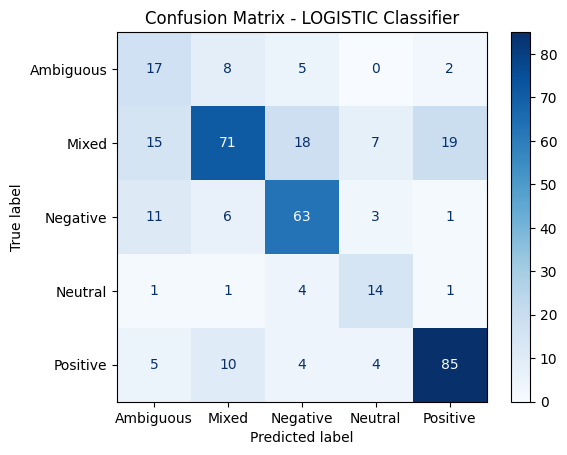


Per-class accuracy:
Class Ambiguous: 0.531
Class Mixed: 0.546
Class Negative: 0.750
Class Neutral: 0.667
Class Positive: 0.787

Class distribution:
Class Ambiguous: 158 samples (8.4%)
Class Mixed: 652 samples (34.8%)
Class Negative: 419 samples (22.4%)
Class Neutral: 103 samples (5.5%)
Class Positive: 542 samples (28.9%)
Training rf classifier...
Accuracy: 0.645

Classification Report:
              precision    recall  f1-score   support

   Ambiguous       0.25      0.03      0.06        32
       Mixed       0.58      0.73      0.65       130
    Negative       0.68      0.71      0.70        84
     Neutral       1.00      0.14      0.25        21
    Positive       0.72      0.77      0.74       108

    accuracy                           0.65       375
   macro avg       0.65      0.48      0.48       375
weighted avg       0.64      0.65      0.61       375



<Figure size 1000x800 with 0 Axes>

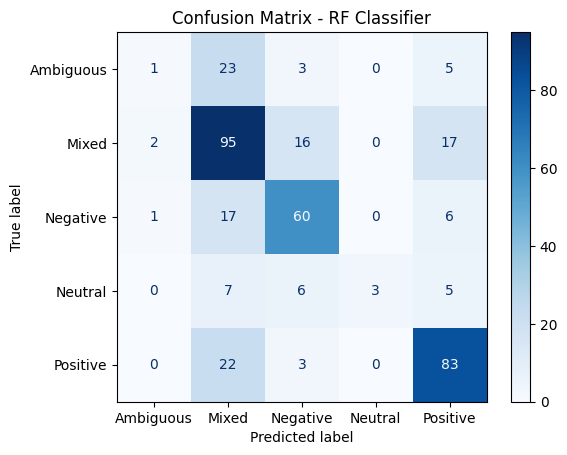


Per-class accuracy:
Class Ambiguous: 0.031
Class Mixed: 0.731
Class Negative: 0.714
Class Neutral: 0.143
Class Positive: 0.769

Class distribution:
Class Ambiguous: 158 samples (8.4%)
Class Mixed: 652 samples (34.8%)
Class Negative: 419 samples (22.4%)
Class Neutral: 103 samples (5.5%)
Class Positive: 542 samples (28.9%)
Training svm classifier...
Accuracy: 0.693

Classification Report:
              precision    recall  f1-score   support

   Ambiguous       0.00      0.00      0.00        32
       Mixed       0.61      0.75      0.67       130
    Negative       0.70      0.77      0.73        84
     Neutral       1.00      0.43      0.60        21
    Positive       0.78      0.82      0.80       108

    accuracy                           0.69       375
   macro avg       0.62      0.55      0.56       375
weighted avg       0.65      0.69      0.66       375



c:\Users\Rafa Parkoureiro\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rafa Parkoureiro\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rafa Parkoureiro\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

<Figure size 1000x800 with 0 Axes>

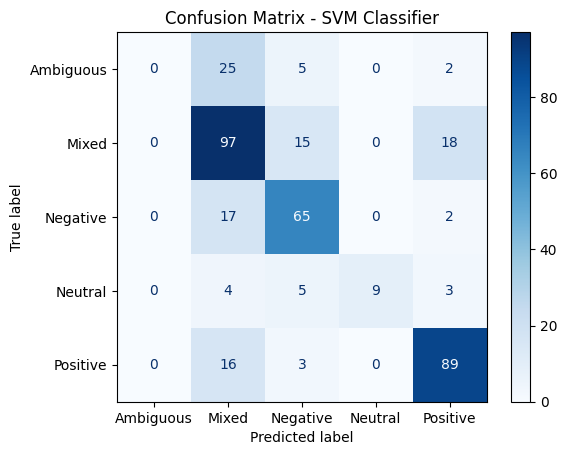


Per-class accuracy:
Class Ambiguous: 0.000
Class Mixed: 0.746
Class Negative: 0.774
Class Neutral: 0.429
Class Positive: 0.824

Class distribution:
Class Ambiguous: 158 samples (8.4%)
Class Mixed: 652 samples (34.8%)
Class Negative: 419 samples (22.4%)
Class Neutral: 103 samples (5.5%)
Class Positive: 542 samples (28.9%)

Model comparison:
Logistic: 0.667
Random Forest: 0.645
SVM: 0.693


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def evaluate_sentiment_model(features, labels, model_type='logistic'):
    """
    Evaluate sentiment model with detailed metrics and confusion matrix visualization.
    
    Args:
        features: Feature array extracted from neural model
        labels: Target labels
        model_type: Type of classifier ('logistic', 'rf', or 'svm')
    """
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        labels,
        test_size=0.2,
        random_state=42,
        stratify=labels  # Ensure balanced classes in train/test
    )
    
    # Select classifier
    if model_type == 'rf':
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_type == 'svm':
        clf = SVC(kernel='linear', probability=True)
    else:  # default to logistic
        clf = LogisticRegression(max_iter=1000, class_weight='balanced')
    
    # Train the model
    print(f"Training {model_type} classifier...")
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.3f}")
    
    # Get class labels
    classes = np.unique(labels)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_type.upper()} Classifier')
    plt.savefig(f'confusion_matrix_{model_type}.png')
    plt.show()
    
    # Calculate per-class accuracy
    print("\nPer-class accuracy:")
    for i, class_label in enumerate(classes):
        class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
        print(f"Class {class_label}: {class_acc:.3f}")
    
    # Check for class imbalance
    print("\nClass distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for u, c in zip(unique, counts):
        print(f"Class {u}: {c} samples ({c/len(labels):.1%})")
    
    return clf, accuracy, cm

# Example usage
features = np.load('sentiment_features.npy')
labels = df['sentiment'].values

# Try different classifiers to see which works best
lr_model, lr_acc, lr_cm = evaluate_sentiment_model(features, labels, 'logistic')
rf_model, rf_acc, rf_cm = evaluate_sentiment_model(features, labels, 'rf')
svm_model, svm_acc, svm_cm = evaluate_sentiment_model(features, labels, 'svm')

# Compare model performance
print(f"\nModel comparison:\nLogistic: {lr_acc:.3f}\nRandom Forest: {rf_acc:.3f}\nSVM: {svm_acc:.3f}")